In [1]:
from keras import layers
from keras import models
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from itertools import cycle
from tensorflow.python.client import device_lib
import itertools
from keras import backend as K
from keras import optimizers
from keras.layers.normalization import BatchNormalization
import tensorflow as tf
from keras.models import load_model
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

print(device_lib.list_local_devices())
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1544785168684701914
]


[]

In [2]:
model1 = load_model('C:/Users/Canpolat/Documents/Uni/masterthesis/voter_Entwurf/best_model_voter1.h5')
model2 = load_model('C:/Users/Canpolat/Documents/Uni/masterthesis/voter_Entwurf/best_model_voter2.h5')
model3 = load_model('C:/Users/Canpolat/Documents/Uni/masterthesis/voter_Entwurf/best_model_voter3.h5')

listM = []
listM.append(model1)
listM.append(model2)
listM.append(model3)



In [3]:
test_dir = "C:/Users/Canpolat/Documents/Uni/masterthesis/potatoes"
test_datagen = ImageDataGenerator(
    rescale=1./255
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

Found 465 images belonging to 3 classes.


In [4]:
def predict(model_list, X, steps, verbose=1):
    predictions = list(map(lambda model: model.predict_generator(X, steps), model_list))
    #print(predictions)
    nb_preds = len(X)
    #print(nb_preds)
    for i, pred in enumerate(predictions):
        pred = list(map(lambda probas: np.argmax(probas, axis=-1), pred))
        #print(pred)
        #print(nb_preds)
        predictions[i] = np.asarray(pred).reshape(465, 1)
        #print(predictions[i])
    argmax_list = list(np.concatenate(predictions, axis=1))
    #print(argmax_list)
    #votes = np.asarray(list(map(lambda arr: max(set(arr)), argmax_list)))
    
    votes = np.asarray(list(map(lambda arr: countOccur(arr), argmax_list)))
    #print(votes.tolist())
    #print(votes.shape)
    return votes.tolist()

In [5]:
def countOccur(arr):
    axis = 0
    u, indices = np.unique(arr, return_inverse=True)
    return u[np.argmax(np.apply_along_axis(np.bincount, axis, indices.reshape(arr.shape), None, np.max(indices) + 1), axis=axis)]
    #return u[np.argmax(np.bincount(indices))]

In [6]:
def getTargetNames(validation_generator):
    dictionary = validation_generator.class_indices
    result = []
    result_indexes = []
    for x in dictionary:
        #print(x)
        result.append(x)
        result_indexes.append(dictionary[x])
    return result, result_indexes

In [7]:
def plotConfusion(confusion, names, validation_generator):
    classes = range(3)

    # create confusion matrix
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion)
    cmap=plt.cm.Blues
    plt.imshow(confusion, interpolation='nearest', cmap=cmap)
    #plt.title('confusion matrix')

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    #plt.yticks(tick_marks, names)

    thresh = confusion.max()/2
    for i, j in itertools.product(range(confusion.shape[0]), range(confusion.shape[1])):
        plt.text(j, i, confusion[i, j], horizontalalignment='center', color='white' if confusion[i, j] > thresh else 'black')

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

    print('Classification Report')

    print(classification_report(validation_generator.classes, y_pred, target_names=names))

[[1.9625031e-05 1.6447257e-03 9.9833566e-01]
 [2.0642951e-01 7.9053688e-01 3.0336946e-03]
 [8.1935865e-01 1.7891446e-01 1.7268618e-03]
 ...
 [1.3098064e-01 8.6445624e-01 4.5630578e-03]
 [8.3001074e-04 9.9917006e-01 1.5111883e-08]
 [1.4676055e-01 8.5320359e-01 3.5951347e-05]]
[[ 44  75  34]
 [ 99  45   8]
 [ 45 106   9]]
Classification Report
              precision    recall  f1-score   support

early_blight       0.23      0.29      0.26       153
     healthy       0.20      0.30      0.24       152
 late_blight       0.18      0.06      0.09       160

    accuracy                           0.21       465
   macro avg       0.20      0.21      0.19       465
weighted avg       0.20      0.21      0.19       465



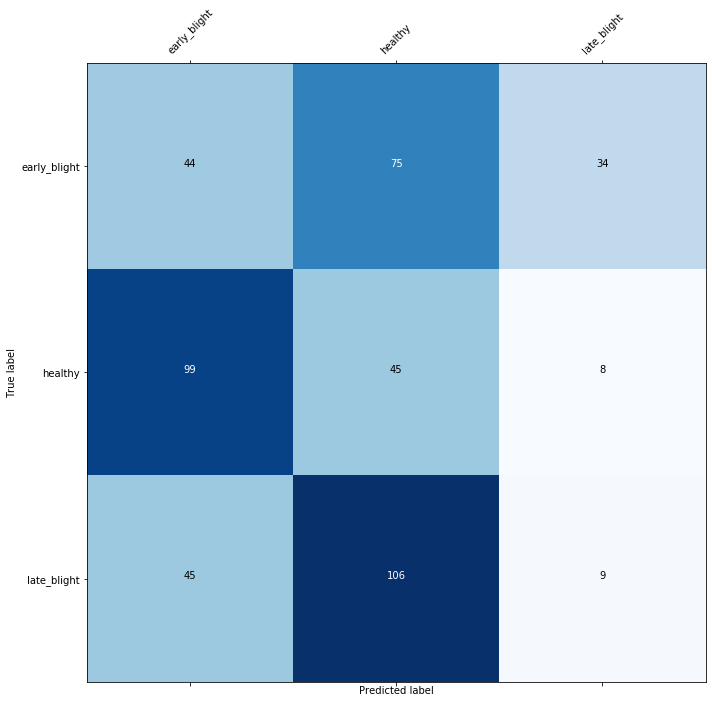

In [8]:
list_of_models = []
list_of_models.append(model1)
list_of_models.append(model2)
list_of_models.append(model3)
#result = model1.predict_generator(test_generator, steps = steps)
#print(result)
steps=np.ceil(465 /32)
pred_of_models =predict(list_of_models, test_generator, steps)

test_generator.reset()
names, index = getTargetNames(test_generator)
num_of_test_samples = 465 #1619
steps=np.ceil(num_of_test_samples//32)+1
Y_pred = model1.predict_generator(test_generator,steps=steps)
print(Y_pred)
y_pred = pred_of_models
#print('Confusion Matrix')
confusion = confusion_matrix(test_generator.classes, y_pred, index)
print(confusion)

plotConfusion(confusion, names, test_generator)
